In [0]:
from tensorflow.keras.layers import RepeatVector, Permute
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from tensorflow.keras.layers import BatchNormalization, RepeatVector, Permute
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec

**Load the Images**

In [0]:
def fetch_images(name, size):
    x_images = []
    y_images = []
    for file in (os.listdir(name)):
        image = Image.open(name+file)
        # print (name+file)
        x_image = image.resize((size[0]//2, size[1]//2))
        x_image = x_image.resize(size, Image.NEAREST)
        x_image = np.array(x_image)
        y_image = image.resize(size)
        y_image = np.array(y_image)
        x_images.append(x_image)
        y_images.append(y_image)
    x_images = np.array(x_images)
    y_images = np.array(y_images)
    x_images = x_images / 255
    y_images = y_images / 255
    return x_images, y_images
ximages, yimages = fetch_images("Train/", (128,128))

In [3]:
input = Input(shape=(128,128, 3))
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
d1 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(c2)

m1 = concatenate([d1, c2],axis=3)

d2 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(m1)

m2 = concatenate([c1, d2],axis=3)

out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(m2)

model = Model(inputs=input, outputs=out)

print (model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(ximages, yimages,validation_split=0.2 , epochs=500, batch_size=8, callbacks = [checkpoint,reduce_lr])

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')

# list of epoch numbers
x = list(range(1,400+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
def load_testimage(name, size):
  x_images = []
  for file in (os.listdir(name)):
      image = Image.open(name + file)
      image = image.resize((size[0]//2, size[1]//2))
      image = image.resize(size, Image.NEAREST)
      image = np.array(image,dtype=float)
      image = image / 255
      image = np.array([image])
      x_images.append(image) 
  return x_images
testimages = load_testimage("Test/", (128,128))

Here the input blurred image

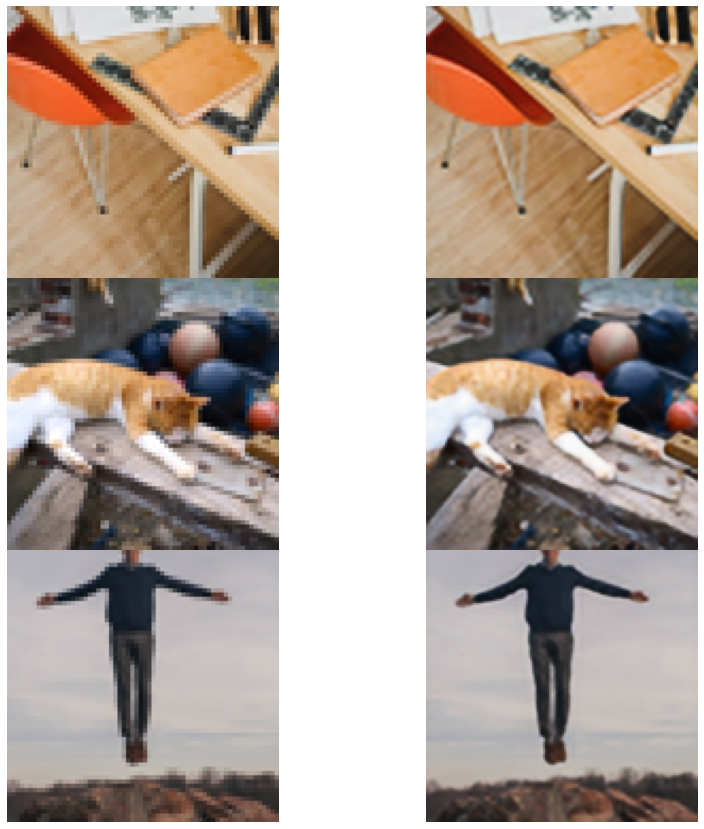

In [12]:
model.load_weights('weights.hdf5')

f, ax = plt.subplots(3,2, sharex='col', sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0},squeeze=True)
plt.subplots_adjust(wspace=None, hspace=None)
f.set_figheight(15)
f.set_figwidth(15)
c = 0
j = 0
for i in range(3):  
  prediction = model.predict(testimages[c])
  prediction = prediction[0] * 255
  prediction = prediction.astype(np.uint8)
  prediction = Image.fromarray(prediction)
  ax[i][j].axis("off")
  ax[i][j].imshow(testimages[c].reshape(128,128,3))
  ax[i][j+1].axis("off")
  ax[i][j+1].imshow(prediction)
  c = c + 1